<section id="title-slide">
  <h1 class="title">The ABC of computational Text Analysis</h1>
  <p class="subtitle">10: NLP with Python</p>
  <p class="author">Alex Flückiger</p>
  <p class="date">7 May 2020</p>
</section>

In [55]:
%%HTML
<style>
div.prompt {display:none}
</style>

# Do NLP

## Modules

#### Standing of the Shoulders of Giants
- [spaCy](https://spacy.io/usage/spacy-101): do Natural Language Processing (NLP)
- [textaCy](https://chartbeat-labs.github.io/textacy/build/html/index.html): do more NLP, extends spaCy
- [scattertext](https://github.com/JasonKessler/scattertext): visualize differences across corpora
- [pandas](https://pandas.pydata.org/docs/getting_started/intro_tutorials/index.html): analyze tabular data 
- [plotnine](https://plotnine.readthedocs.io/en/stable/): visualize anything (ggplot for Python)

# Importing Modules

various ways of importing

In [56]:
# standard import
import textacy
import spacy

# import with shortname
import scattertext as st 
import pandas as pd

# import all specific/all objects from a module
from pathlib import Path
from plotnine import *
import textacy.vsm

# Basic NLP

In [57]:
# define text directly (to read a file see below)
text = "Apple is looking at buying U.K. startup for $1 billion"

# load a language specific model
en = textacy.load_spacy_lang("en_core_web_sm")

# analyze document (tokenizing, tagging, parsing)
doc = textacy.make_spacy_doc(text, lang=en)

# iterate over tokens per document
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_,
            token.dep_, token.shape_, token.is_alpha, token.is_stop)

Apple Apple PROPN NNP nsubj Xxxxx True False
is be AUX VBZ aux xx True True
looking look VERB VBG ROOT xxxx True False
at at ADP IN prep xx True True
buying buy VERB VBG pcomp xxxx True False
U.K. U.K. PROPN NNP compound X.X. False False
startup startup NOUN NN dobj xxxx True False
for for ADP IN prep xxx True True
$ $ SYM $ quantmod $ False False
1 1 NUM CD compound d False False
billion billion NUM CD pobj xxxx True False


In [58]:
# alternatively, read from a single txt file 
f_text = '../materials/swiss_party_programmes/txt/sp_programmes/1920_parteiprogramm_d.txt'
text = textacy.io.read_text(f_text)

# show content
# special generator syntax as text is read just-in-time (streaming)
print(next(text)[:200])

Programm der Sozialdemokratischen Partei der
Schweiz
(Angenommen durch den Parteitag vom 10./12. Dezember 1920 in Bern.)

Prinzipienerklärung.
Das Endziel der Sozialdemokratie bildet eine Gesellschaft


# Working with a Corpus

# Create a Corpus I

How to make a corpus from text files?

1. index files
2. read file content
3. parse metadata from file name
4. return each document sequentially

&rarr; wrap all this in a function `get_texts()`

In [59]:
def get_texts(dir_texts):
    """
    Sequentially stream all documents from a given folder,
    including metadata.
    """
    p = Path(dir_texts) # set base dir
    
    # iterate over all documents
    for fname in p.glob('**/*.txt'):
        
        print('Parsing file:', fname.name)
        
        content = next(textacy.io.text.read_text(fname))
        # join lines as there are hard line-breaks
        content = content.replace('\n', ' ')
        # further modify the text content here if needed

        # parse year from filename and set a metadata
        # example: 1920_parteiprogramm_d.txt --> year=1920
        try:
            year = int(fname.name.split('_')[0])
        except ValueError:
            print('WARNING: Parsing meta data failed:',
                  fname.name)
            continue

        # add more metadata here if needed
        metadata = {'fname': fname.name, 'year': year}
        
        # return documents one after another (sequentially)
        yield (content, metadata)

# Create a Corpus II


In [60]:
# stream texts from a given folder
dir_texts = '../materials/swiss_party_programmes/txt/sp_programmes/'
texts = get_texts(dir_texts)

# load German language model
de = textacy.load_spacy_lang("de_core_news_sm")

# create corpus from processed documents
corpus = textacy.Corpus(de, data=texts)

Parsing file: 1920_parteiprogramm_d.txt
Parsing file: 1982_parteiprogramm_d_0.txt
Parsing file: 1888_parteiprogramm_d_0.txt
Parsing file: sp-parteiprogramm_definitiv-de_0.txt
Parsing file: 1904_parteiprogramm_d_0.txt
Parsing file: 1959_parteiprogramm_d_0.txt
Parsing file: 1870_parteiprogramm_d_0.txt
Parsing file: 1935_parteiprogramm_d_0.txt


# Basic Corpus Statistics

In [61]:
print('# documents:', corpus.n_docs)
print('# sentences:', corpus.n_sents)
print('# tokens:', corpus.n_tokens)

# documents: 7
# sentences: 3359
# tokens: 45598


# Export Word Counts

In [62]:
# get lowercased and filtered corpus vocabulary
vocab = corpus.word_counts(as_strings=True, normalize= 'lower', filter_stops = True, filter_punct = True, filter_nums = True)

# sort vocabulary by descending frequency
vocab_sorted = sorted(vocab.items(), key=lambda x: x[1], reverse=True)

# write to file, one word and its frequency per line
fname = '../analysis/vocab_frq.txt'
with open(fname, 'w') as f:   
    for word, frq in vocab_sorted:
        line = f"{word}\t{frq}\n"
        f.write(line)

vocab_sorted[:5]

[('menschen', 112),
 ('partei', 101),
 ('demokratie', 94),
 ('entwicklung', 92),
 ('staat', 92)]

# Working with Subcorpus

Interested in a group of documents only?

In [63]:
# function to filter by metadata, e.g. publication year after 1900
filter_func = lambda doc: doc._.meta.get("year") > 1900

# create new corpus after applying filter function
subcorpus = textacy.corpus.Corpus(de, data=corpus.get(filter_func))

subcorpus.n_docs, corpus.n_docs

(5, 7)

In [64]:
# select the first document in corpus
first_doc = corpus[0]
first_doc._.meta

{'fname': '1920_parteiprogramm_d.txt', 'year': 1920}

# Key Word in Context (KWIC)

show words in their original context

In [65]:
# iterate over documents and print matches
# you can use regular expressions as keyword
for doc in corpus:
    results = textacy.text_utils.keyword_in_context(doc.text, keyword = '(Ausland|Inland)', ignore_case = True, window_width = 50, print_only = True)
    for match in results:
        print(doc.text)

wärts beziehen und für seine Industrieprodukte im  Ausland  Absatz suchen muss, deshalb von allen Schwankunge
 Unterstützung von in Not geratenen Schweizern im  Ausland . Unterstützung und Förderung aller Bestrebungen, 
eaktion, weil die Schweiz in mancher Hinsicht vom  Ausland  abhängig und weltweiten Zwängen ausgesetzt ist. U
eren multinational. Produktionsstätten werden ins  Ausland  verlagert und einheimische Betriebe von multinati
chränkungen. Die Schweiz ist nicht nur selbst vom  Ausland  abhängig, sie schafft auch Abhängigkeiten. Wie an
ine Beschränkung der Futtermittel-lmporte aus dem  Ausland .  39  (26) Landwirtschaftspolitik  ❑ Die Einkomme
piel einer wirksamen Massnahme. 2. Das Risiko der  Ausland abhängigkeit der Energieversorgung soll reduziert 
 der Radioaktivität eine untragbare Hypothek, die  Ausland abhängigkeit (Uran) enorm und die Sicherheit (Unfa
te und landwirtschaftlichen Erzeugnisse Absatz im  Ausland e suchen muss und deshalb von allen Schwankungen u
Interesse 

# Export Results to File

collect any information and write to file

In [66]:
results = []

for doc in corpus:
    for sent in doc.sents:
        if 'Armut' in sent.text:
            # match starts with the sentence, followed by the filename (tab-separated)
            match = f"{sent.text}\t{doc._.meta['fname']}"
            results.append(match)

fname = '../analysis/sents_poverty.txt'
with open(fname, 'w') as f:
    f.write('\n'.join(results))

print(match)

Die sozialistische Gesellschaft wird sich bestreben, durch die Befriedigung der Bedürfnisse aller Arbeitenden und durch die Fürsorge für alle Arbeitsunfähigen Armut und Not, Verbrechen und Prostitution, die in den Zuständen des Kapitalismus ihren Nährboden fanden, als gesellschaftliche Erscheinung zum Verschwinden zu bringen.	1935_parteiprogramm_d_0.txt


# Export Corpus

In [67]:
# pretty complex syntax to
# merge metadata and actual content for each document in the corpus
data = [{**doc._.meta, **{'text': doc.text}} for doc in corpus]

# export corpus as csv
f_csv = '../materials/corpus_party_programmes.csv'
textacy.io.csv.write_csv(data, f_csv, fieldnames=data[0].keys())

# csv format is the best to load in scattertext

# Explore Corpus interactively

![Example Scattertext](../analysis/viz_party_differences.png)

# Scattertext

- how does language differ by
    - organization, person, gender, time etc.
- interactive exploring
- find discriminative terms 
    - *unigrams* + *bigrams*
- scoring function *rank-frequency*
    - normalized by number of terms [0,1]

# Load CSV File

load a dataset of 1 August speeches by Swiss federal councillors

In [68]:
# read dataset from csv file
f_csv = '../materials/dataset_speeches_federal_council_2019.csv'
df = pd.read_csv(f_csv)

# filter out non-german texts or very short texts
df_sub = df[(df['Sprache'] == 'de') & (df['Text'].str.len() > 10)]

# make new column containing all relevant metadata (to show in plot)
df_sub['descripton'] = df_sub[['Redner', 'Partei', 'Jahr']].astype(str).agg(', '.join, axis=1)

# sneak peek of dataset
df_sub.head()

,Jahr,Status,Vollständigkeit,Redner,Geschlecht,Funktion,Partei,Partei-Original,Typ,Bemerkung,Sprache,Originalsprache,Ort,Titel,Anrede,Text,Originaltext,Quelle,descripton
0,2018,done,vollständig,Alain Berset,m,BP,SP,SP,BP-Rede,NaN,de,NaN,NaN,NaN,Sehr geehrte Damen und Herren,Wir leben in der Schweiz in Frieden und Wohlst...,NaN,https://www.admin.ch/gov/de/start/dokumentatio...,"Alain Berset, SP, 2018"
3,2018,done,vollständig,Doris Leuthard,f,BR,CVP,CVP,Lokal,NaN,de,NaN,Villmergen,NaN,Liebe Mitbürgerinnen und Mitbürger,Ich bedanke mich für die Einladung zu Ihrer 1....,NaN,https://www.admin.ch/gov/de/start/dokumentatio...,"Doris Leuthard, CVP, 2018"
4,2018,done,vollständig,Guy Parmelin,m,BR,SVP,SVP,Lokal,NaN,de,NaN,NaN,«Armbrust und Hellebarde»,"Sehr geehrte Eidgenossen, Meine Damen und Herren",Eine 1.-August-Rede ist eine der heikelsten rh...,NaN,https://www.admin.ch/gov/de/start/dokumentatio...,"Guy Parmelin, SVP, 2018"
5,2018,done,vollständig,Ignazio Cassis,m,BR,FDP,FDP,Lokal,NaN,de,NaN,Rorschach,Die Italianità hat ihre Wurzeln in Rorschach,Gueten Obig mitenand!,Und danke für diese freundliche Einladung!\nIc...,NaN,https://www.admin.ch/gov/de/start/dokumentatio...,"Ignazio Cassis, FDP, 2018"
6,2018,done,vollständig,Simonetta Sommaruga,f,BR,SP,SP,Lokal,NaN,de,NaN,Muttenz,Heimat kennt keine Grenzen,"Liebe Festgemeinde,\nSehr geehrter Herr Regier...",Als ich die Einladung zu dieser Bundesfeier ge...,NaN,https://www.ejpd.admin.ch/ejpd/de/home/aktuell...,"Simonetta Sommaruga, SP, 2018"


In [69]:
# tags to ignore in corpus, e.g. numbers
censor_tags = set(['CARD'])

# stop words to ignore in corpus
de_stopwords = spacy.lang.de.stop_words.STOP_WORDS # default stop words
custom_stopwords = set(['[', ']', '%'])
de_stopwords = de_stopwords.union(custom_stopwords) # extend with custom stop words

# create corpus from dataframe
# lowercased terms, no stopwords, no numbers
# use lemmas for English only, German quality is too bad
corpus_speeches = st.CorpusFromPandas(df_sub, # dataset
                             category_col='Partei', # index differences by ...
                             text_col='Text', 
                             nlp=de, # German model
                             feats_from_spacy_doc=st.FeatsFromSpacyDoc(tag_types_to_censor=censor_tags, use_lemmas=False),
                             ).build().get_stoplisted_unigram_corpus(de_stopwords)

# produce visualization (interactive html)
html = st.produce_scattertext_explorer(corpus_speeches,
            category='SP', # set attribute to divide corpus into two parts
            category_name='SP',
            not_category_name='other parties',
            metadata=df_sub['descripton'],
            width_in_pixels=1000,
            minimum_term_frequency=5, # drop terms occurring less than 5 times
            save_svg_button=True,                          
)

# write visualization to html file
fname = "../analysis/viz_party_differences.html"
open(fname, 'wb').write(html.encode('utf-8'))

2457521

# Plot Term Frequencies over Time

![Example](../analysis/rel_term_frq_nation.png)

# Create Corpus III

How to make a corpus from a dataset in `.csv`-format?

&rarr; define a new function `get_texts_from_csv`, similar to `get_texts`

In [70]:
def get_texts_from_csv(f_csv, text_column):
    """
    Read dataset from a csv file and sequentially stream the rows,
    including metadata.
    """
    
    # read dataframe
    df = pd.read_csv(f_csv)
    
    # keep only documents that have text
    filtered_df = df[df[text_column].notnull()]
    
    # iterate over rows in dataframe
    for idx, row in filtered_df.iterrows():
        
        # read text and join lines (remove hard line-breaks)
        text = row[text_column].replace('\n', ' ')

        # use all columns as metadata, except the column with the actual text
        metadata = row.to_dict()
        del metadata[text_column]

        yield (text, metadata)

f_csv = '../materials/dataset_speeches_federal_council_2019.csv'
texts = get_texts_from_csv(f_csv, text_column='Text')

corpus_speeches = textacy.Corpus(de, data=texts)

In [71]:
# define what groups are formed and what should be included as words
# here, groups by year and words are lowercased (unigram, incl. stop words)
tokenized_docs, groups = textacy.io.unzip(
        (doc._.to_terms_list(normalize='lower', ngrams=1, entities=False, as_strings=True, filter_stops=False),
         doc._.meta["Jahr"])
        for doc in corpus_speeches)

# define how to count
# here relative term frequency
vectorizer = textacy.vsm.GroupVectorizer(
        tf_type='linear', # absolute term frequency
        apply_dl=True, # normalized by document length
        dl_type="linear",
        vocabulary_grps=range(1950, 2019)) # limit to years from 1950 to 2019

# produce group-term-matrix with with frequency counts
grp_term_matrix = vectorizer.fit_transform(tokenized_docs, groups)

# create dataframe from matrix
df_terms = pd.DataFrame.sparse.from_spmatrix(grp_term_matrix, index=vectorizer.grps_list, columns=vectorizer.terms_list)
df_terms['year'] = df_terms.index.values

# change shape of dataframe
df_tidy = df_terms.melt(id_vars='year', var_name="term", value_name="frequency")
df_tidy

,year,term,frequency
0,1950,'s,0.000000
1,1951,'s,0.000000
2,1952,'s,0.000000
3,1953,'s,0.000000
4,1954,'s,0.000000
...,...,...,...
1249309,2014,►,0.000000
1249310,2015,►,0.000000
1249311,2016,►,0.000000
1249312,2017,►,0.000000


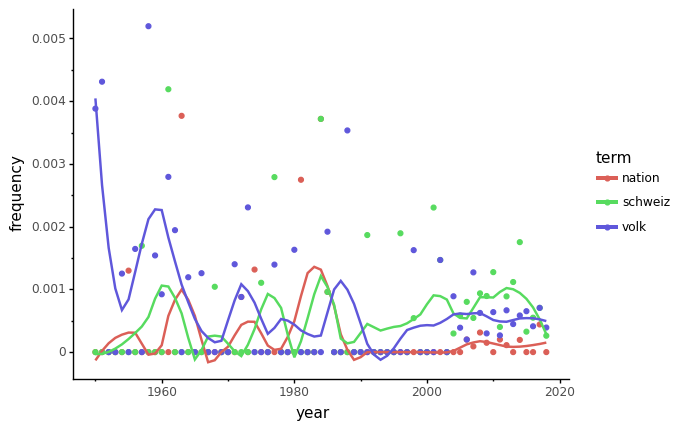

<ggplot: (8765705850459)>

In [72]:
# filter the dataset for the following terms
terms = ["volk", "schweiz", "nation"]
df_terms = df_tidy[df_tidy['term'].isin(terms)]

# plot the relative frequency for the terms above
(ggplot(df_terms, aes(x='year', y='frequency', color='term'))
 + geom_point() # show individual points
 + stat_smooth(method='loess', span=0.2, se=False) # overlay points with a smoothed line
 + theme_classic()) # make the plot look nicer

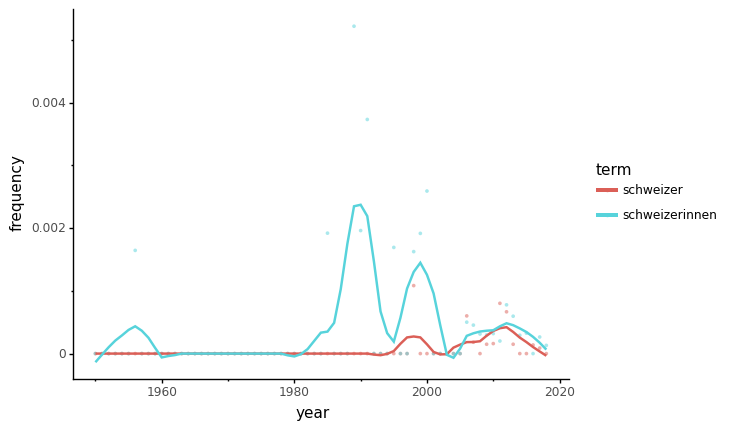

<ggplot: (8765684101021)>

In [73]:
# check some other terms
terms = ["schweizer", "schweizerinnen"]
df_terms = df_tidy[df_tidy['term'].isin(terms)]

p = (ggplot(df_terms, aes('year', 'frequency', color='term'))
 + geom_point(alpha=0.5, stroke = 0) # set transparency
 + stat_smooth(method='loess', span=0.2, se=False)
 + theme_classic())

# save as png
fname = '../analysis/rel_term_frq_gender.png'
p.save(filename=fname, dpi=150, verbose = False)
p

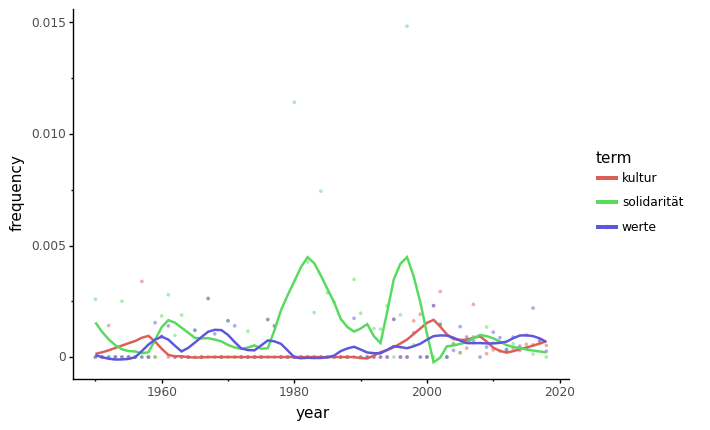

<ggplot: (8765683377270)>

In [74]:
# check some other terms

terms = ["solidarität", "kultur", "werte"]

df_terms = df_tidy[df_tidy['term'].isin(terms)]

(ggplot(df_terms, aes('year', 'frequency', color='term'))
 + geom_point(alpha=0.5, stroke = 0)
 + stat_smooth(method='loess', span=0.2, se=False)
 + theme_classic())

# Number of Documents per Year

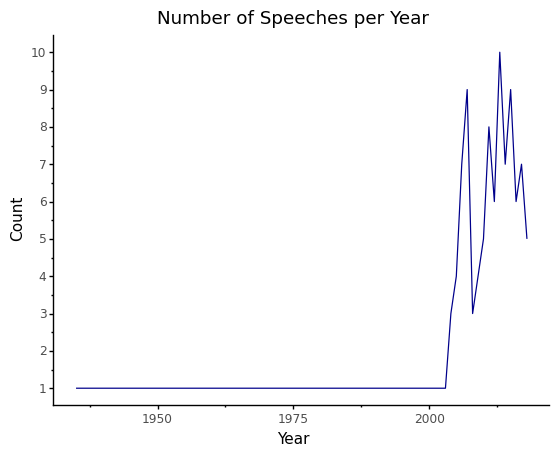

<ggplot: (8765684207023)>

In [75]:
docs_per_year = df_sub.groupby('Jahr').agg({'Text': "count" }).reset_index().rename(columns={'Text':'count'})

(ggplot(docs_per_year, aes(x='Jahr', y='count'))
 + geom_line(color='darkblue')
 +  labs(title = "Number of Speeches per Year", x = "Year", y = "Count")
 + scale_y_continuous(breaks=range(0, 12))
 + theme_classic())

# Outlook: NLP is on Fire 🔥


- Named Entity Recognition (NER)
  - *organizations, persons, locations, time etc.*
- word embeddings
  - *continious vectors instead of discrete symbols*
- extract structured information
  - *A does X to B*
- train classifiers to predict

# Working on Mini-Project

Ask questions, <br>
I am ready to help!

![Help!](../slides/images/help_frog.gif)


# In-class: Exercises I

1. Make sure that your local copy of the Github repository KED2020 is up-to-date with `git pull`. You can find the code of this notebook as python script: `scripts/KED2020_10.py` along with the used dataset in `materials/dataset_speeches_federal_council_2019.csv`.

2. Open `scripts/KED2020_10.py` in Spyder.

3. Play around with the code is a good way to learn. Modify one thing, run the code, and see if the output matches your expectations.

4. Come up with your own terms for the KWIC and the frequency plot.

5. Getting bored? Check out the documentation of the packages linked above.


# Resources

#### tutorials on spaCy

- [Official spaCy 101](https://spacy.io/usage/spacy-101)

- [Hitchhiker's Guide to NLP in spaCy](https://www.kaggle.com/nirant/hitchhiker-s-guide-to-nlp-in-spacy)